In [4]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.datasets.folder import default_loader, IMG_EXTENSIONS
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from PIL import Image
from torch.utils.data import (TensorDataset, 
                              Dataset, 
                              Subset,
                              random_split,
                              DataLoader,
                              RandomSampler, 
                              SequentialSampler, 
                              )
from transformers import BertTokenizer, BertForSequenceClassification
from models import initialize_vision_model, initialize_language_model
from GarbageUtils import GarbageDataset, split_dataset, GarbageImageFolder, append_value

import transformers

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [5]:
from torchvision.models import (inception_v3, 
                                Inception_V3_Weights,
                                efficientnet_b7, 
                                EfficientNet_B7_Weights, 
                                mobilenet_v2, 
                                MobileNet_V2_Weights)
                                

In [6]:
model_ft = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
model_ft

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [7]:
print(f'Device: {device}')
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Transformers Version: ", transformers.__version__)

torch.cuda.empty_cache()



Device: cuda
PyTorch Version:  2.5.1+cu118
Torchvision Version:  0.20.1+cu118
Transformers Version:  4.46.3


In [8]:
data_dir = "C:/Users/bloy77/Desktop/Fall 2024 Course Materials/Digital Engineeering/Project/data"
vision_model_name = "mobilenet_v2"
language_model_name = "bert-base-uncased"
num_classes = 4
batch_size = 16 #4 #32 #16
epochs = 100
feature_extract = True

# remember to set your CSV_NAME and PATH to save model weights
learning_rate = 0.001
CSV_NAME = "100epochs_lr_0_001_mobilenet_v2_bs16.csv"
PATH = "100epochs_lr_0_001_mobilenet_v2_bs16.pth"

In [9]:
if language_model_name == "bert-base-uncased":
    out_features = 2052

In [10]:
if vision_model_name == "inception":
    out_features = 2052
elif vision_model_name == "efficientnet_b7":
    out_features = 2564
elif vision_model_name == "mobilenet_v2":
    out_features = 1284

In [11]:
vision_model, input_size = initialize_vision_model(vision_model_name, num_classes, feature_extract, multimodal=True)
language_model, tokenizer = initialize_language_model(language_model_name, num_classes, multimodal=True)


Initializing MobileNetV2 with weights=MobileNet_V2_Weights.DEFAULT ...
Input size = 224


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Initializing Bert-Base-Uncased...


In [12]:
vision_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
def validate_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

image_dataset = GarbageImageFolder(data_dir, is_valid_file=validate_image)

In [14]:
image_dataset = GarbageImageFolder(data_dir, is_valid_file=validate_image)

In [15]:
classes =  image_dataset.classes
num_classes = len(classes)
print(classes)
print(f'Num of Classes: {num_classes}')

['black', 'blue', 'green', 'other']
Num of Classes: 4


In [16]:
image_dataset.class_to_idx

{'black': 0, 'blue': 1, 'green': 2, 'other': 3}

In [17]:
a = slice(-3, -1)
image_dataset[0:6]

[(<PIL.Image.Image image mode=RGB size=800x800>, 0),
 (<PIL.Image.Image image mode=RGB size=800x800>, 0),
 (<PIL.Image.Image image mode=RGB size=800x800>, 0),
 (<PIL.Image.Image image mode=RGB size=800x800>, 0),
 (<PIL.Image.Image image mode=RGB size=800x800>, 0),
 (<PIL.Image.Image image mode=RGB size=1734x1301>, 0)]

In [18]:
image_dataset[a]

[(<PIL.Image.Image image mode=RGB size=1155x1600>, 3),
 (<PIL.Image.Image image mode=RGB size=2615x3044>, 3)]

In [19]:
train_set, val_set, test_set = split_dataset(image_dataset.imgs, test_size=0.2)

In [20]:
def get_dataloaders(input_size, train_set, val_set, test_set):
    from torchvision import datasets, transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    train_set = GarbageDataset(train_set, is_subset=False, transform=data_transforms['train'])
    val_set = GarbageDataset(val_set,  is_subset=False, transform=data_transforms['val'])
    test_set = GarbageDataset(test_set,  is_subset=False, transform=data_transforms['val'])
    
    print("Loading data...")
    print(f'Train set size: {len(train_set)}')
    print(f'Val set size: {len(val_set)}')
    print(f'Test set size: {len(test_set)}')
    
    dataloaders_dict = {
        'train': DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=4, drop_last=True),
        'val': DataLoader(val_set, batch_size = batch_size, shuffle=False, num_workers=4, drop_last=True)
    }
    
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
    
#     print("Loading Datasets and Initializing DataLoaders...")
    return test_dataloader, dataloaders_dict

test_dataloader, dataloaders_dict = get_dataloaders(input_size, train_set, val_set, test_set)

Loading data...
Train set size: 2224
Val set size: 742
Test set size: 741


In [23]:
class MultiModalGarbageModel(torch.nn.Module):
    def __init__(self, num_classes, text_module, vision_module, text_module_name, vision_module_name,
                 out_features_combined, dropout_p=None):
        super(MultiModalGarbageModel, self).__init__()
        self.text_module = text_module
        self.vision_module = vision_module
        self.text_module_name = text_module_name
        self.vision_module_name = vision_module_name
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(out_features_combined, int(out_features_combined/2)),
            nn.ReLU(),
            nn.Linear(int(out_features_combined/2), num_classes),
        )

    def forward(self, vision_data, text_data, attention_mask):
        text_out, vision_out = 0, 0
        
        # get output from vision model
        if self.vision_module_name == "inception":
            self.vision_module.aux_logits = False
            vision_out = self.vision_module(vision_data)
        else:
            vision_out = self.vision_module(vision_data)

        # get output from text model    
        if self.text_module_name == "bert-base-uncased":
            out = self.text_module(text_data, attention_mask)
            text_out = out[0]
        else:
            text_out = self.text_module(text_data, attention_mask)
            
        combined = torch.cat((vision_out, text_out), dim=1)
        combined = combined.view(combined.size(0), -1)
        logits = self.linear_relu_stack(combined)
#         combined = self.fc(combined)
        
        return logits

In [24]:
model = MultiModalGarbageModel(num_classes, language_model, vision_model, language_model_name,
                                          vision_model_name, out_features)

In [33]:
def train_model(model, dataloaders, criterion, optimizer, epochs=25, is_inception=False, result_dict=None):
    since = time.time()
    
    val_acc_history = list()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, epochs+1):
        print(f'Epoch {epoch+1}/{epochs}')
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over the data # image_file, label, input_ids, attention_mask, file_name
            for inputs, labels, in_ids, att_mask in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                in_ids = in_ids.to(device)
                att_mask = att_mask.to(device)
                
                optimizer.zero_grad() # to zero the parameter gradients
                
                # forward, track history if only in train mode
                with torch.set_grad_enabled(phase == "train"):
                   # outputs = model(inputs, in_ids, att_mask)
                    #loss = criterion(outputs, labels)
                    if is_inception and phase == "train":
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs, in_ids, att_mask)
                        loss = criterion(outputs, labels)
                       # outputs = model(inputs)
                        #loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    # backward, optimize only if in train mode
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss} Accuracy: {epoch_acc}')
            print('-' * 59)
            print('| Epoch {:3d}/{:3d} | {} Loss: {:8.3f} | {} Accuracy {:8.3f} |'.format(
                epoch, epochs, phase, epoch_loss, phase, epoch_acc))
            print('-' * 59)
            
            if result_dict is not None:
                append_value(result_dict, "Epoch", epoch)
                append_value(result_dict, phase+" Accuracy", epoch_acc)
                append_value(result_dict, phase+" Loss", epoch_loss)
            
            # deepcopy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        print()
        
    time_elapsed = time.time() - since
    print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:.04f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history

In [34]:
device = torch.device("cpu")
model = model.to(device)


In [36]:
# send model to device: gpu or cpu
model = model.to(device)

params_to_update = model.parameters()
print("Parameters to learn:")
if feature_extract:
    params_to_update = list()
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
            
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)

Parameters to learn:
	 text_module.bert.embeddings.word_embeddings.weight
	 text_module.bert.embeddings.position_embeddings.weight
	 text_module.bert.embeddings.token_type_embeddings.weight
	 text_module.bert.embeddings.LayerNorm.weight
	 text_module.bert.embeddings.LayerNorm.bias
	 text_module.bert.encoder.layer.0.attention.self.query.weight
	 text_module.bert.encoder.layer.0.attention.self.query.bias
	 text_module.bert.encoder.layer.0.attention.self.key.weight
	 text_module.bert.encoder.layer.0.attention.self.key.bias
	 text_module.bert.encoder.layer.0.attention.self.value.weight
	 text_module.bert.encoder.layer.0.attention.self.value.bias
	 text_module.bert.encoder.layer.0.attention.output.dense.weight
	 text_module.bert.encoder.layer.0.attention.output.dense.bias
	 text_module.bert.encoder.layer.0.attention.output.LayerNorm.weight
	 text_module.bert.encoder.layer.0.attention.output.LayerNorm.bias
	 text_module.bert.encoder.layer.0.intermediate.dense.weight
	 text_module.bert.encode

In [37]:
result_dict = {}
criterion = nn.CrossEntropyLoss()
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, epochs = 100, result_dict=result_dict,)

Epoch 2/100
----------
train Loss: 1.33895673254411 Accuracy: 0.3862410071942446
-----------------------------------------------------------
| Epoch   1/100 | train Loss:    1.339 | train Accuracy    0.386 |
-----------------------------------------------------------
val Loss: 1.2615492890144615 Accuracy: 0.444743935309973
-----------------------------------------------------------
| Epoch   1/100 | val Loss:    1.262 | val Accuracy    0.445 |
-----------------------------------------------------------

Epoch 3/100
----------
train Loss: 1.2044839378741148 Accuracy: 0.5188848920863309
-----------------------------------------------------------
| Epoch   2/100 | train Loss:    1.204 | train Accuracy    0.519 |
-----------------------------------------------------------
val Loss: 1.111233947733342 Accuracy: 0.5754716981132075
-----------------------------------------------------------
| Epoch   2/100 | val Loss:    1.111 | val Accuracy    0.575 |
-----------------------------------------

In [38]:
for x in range(1, 1062):
    if 1062%x == 0:
        print(f'rem: {1062%x} --> {x}')

rem: 0 --> 1
rem: 0 --> 2
rem: 0 --> 3
rem: 0 --> 6
rem: 0 --> 9
rem: 0 --> 18
rem: 0 --> 59
rem: 0 --> 118
rem: 0 --> 177
rem: 0 --> 354
rem: 0 --> 531


In [39]:
import numpy as np
import pandas as pd

In [40]:
model_copy = model

In [41]:
CSV_NAME = "100epochs_lr_0.01.csv"
PATH = "100_epochs_lr_0.01.pth"

In [42]:
torch.save(model.state_dict(), PATH)

In [43]:
result_dict2 = result_dict

In [44]:
result_dict2['Epoch'] = list(dict.fromkeys(result_dict2['Epoch']))

In [45]:
result_dict2['train Accuracy'] = list(acc.item() for acc in result_dict2['train Accuracy'])

In [46]:
result_dict2['val Accuracy'] = list(acc.item() for acc in result_dict2['val Accuracy'])

In [47]:
df = pd.DataFrame.from_dict(result_dict2)

In [48]:
df

,Epoch,train Accuracy,train Loss,val Accuracy,val Loss
0,1,0.386241,1.338957,0.444744,1.261549
1,2,0.518885,1.204484,0.575472,1.111234
2,3,0.571043,1.075992,0.592992,0.983501
3,4,0.607014,0.958367,0.605121,0.927627
4,5,0.642086,0.841827,0.675202,0.741624
...,...,...,...,...,...
95,96,0.736960,0.662957,0.680593,0.765041
96,97,0.749550,0.628793,0.702156,0.741515
97,98,0.751799,0.633002,0.702156,0.740720
98,99,0.756745,0.626846,0.694070,0.745826


In [49]:
df.to_csv(CSV_NAME)

In [50]:
model = MultiModalGarbageModel(num_classes, language_model, vision_model, language_model_name,
                                          vision_model_name, out_features)
model.load_state_dict(torch.load(PATH))

C:\Users\bloy77\AppData\Local\Temp\ipykernel_12212\1967875477.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [52]:
#Imports for confusion matrix.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [53]:
def evaluate(test_loader):

    #actual vs predicted label list for confusion matrix
    actual_label = []
    predict_label = []

    #For incorrect lists.
    incorrect_samples = []
    incorrect_labels = []
    incorrect_pred_labels = []
    incorrect_filenames = []

    # Test loop
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(): # inputs, labels, in_ids, att_mask
        for batch in test_loader:
            image_input, labels, input_ids, attention_mask = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            image_input = image_input.to(device)
            #add the actual label for confusion matrix
            actual_label.extend(labels.cpu().numpy())
            
            outputs = model(image_input, input_ids, attention_mask=attention_mask)
            logits = outputs
            _, predicted = torch.max(logits, 1)
            #add predicted label for confusion matrix
            predict_label.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            #For each batch, store a mask of incorrect indices, then append the info to the lists
            incorrect_index = ((predicted == labels.view_as(predicted)) == False).view(-1)
            incorrect_samples.append(image_input[incorrect_index].cpu().numpy())
            incorrect_labels.append(labels[incorrect_index].cpu().numpy())
            incorrect_pred_labels.append(predicted[incorrect_index].cpu().numpy())

            #Get filenames using batch decode
            decoded_names = tokenizer.batch_decode(input_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            incorrect_filenames_by_batch = []

            #Store in incorrect_filenames based on the incorrect_index mask
            for i in range(len(incorrect_index)):
                if incorrect_index[i]:
                    incorrect_filenames_by_batch.append(decoded_names[i])
            incorrect_filenames.append(incorrect_filenames_by_batch)

    #Show the confusion matrix at the end.
    conf_matrix = confusion_matrix(actual_label, predict_label)
    ConfusionMatrixDisplay(conf_matrix).plot()

    #For misclassified labels
    fig = plt.figure(figsize=(8, 10))

    #Loop through first entry in each batch [idx][0]
    for idx in np.arange(5):
        ax = fig.add_subplot(3, 2, idx+1, xticks=[], yticks=[])
        misclassified_data = incorrect_samples[idx][0]
        misclassified_data = misclassified_data/2 + 0.5
        msc_image = misclassified_data
        msc_image = np.clip(msc_image, 0, 1)
        msc_image = msc_image.T
        plt.imshow(np.squeeze(msc_image))
        plt.title('actual_label: {0} predicted_label: {1}\n object name: {2} '
                  .format(incorrect_labels[idx][0], incorrect_pred_labels[idx][0], incorrect_filenames[idx][0]), wrap=True)
        
    plt.show()
            
    return correct/total

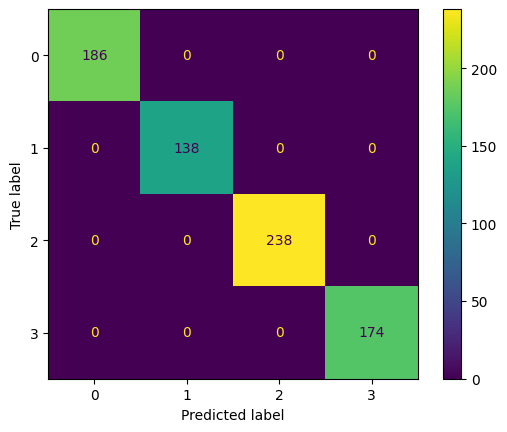

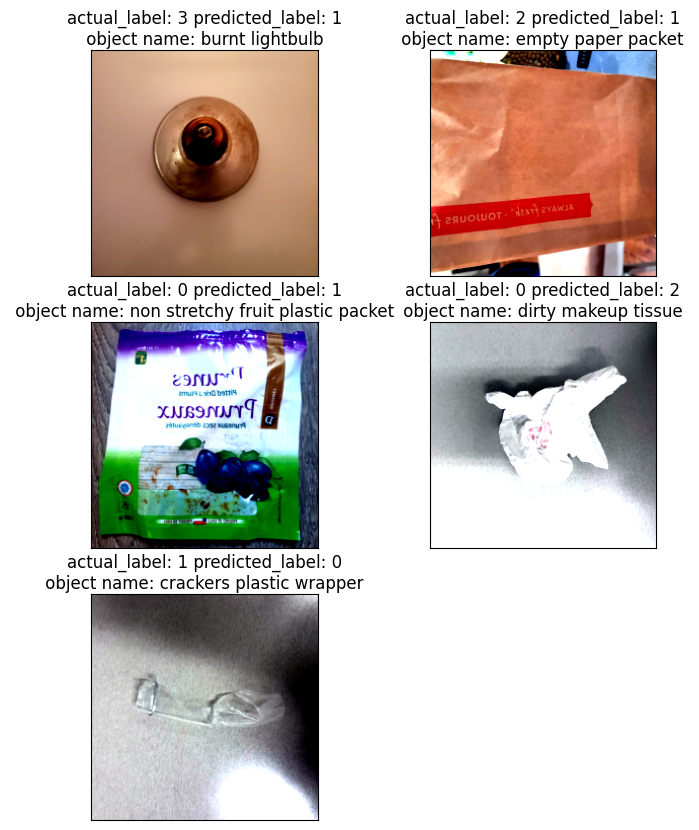

0.7853260869565217

In [54]:
test = evaluate(test_dataloader)
test

In [58]:
model_copy.state_dict()

OrderedDict([('text_module.bert.embeddings.word_embeddings.weight',
              tensor([[-0.0102, -0.0615, -0.0265,  ..., -0.0199, -0.0372, -0.0098],
                      [-0.0117, -0.0600, -0.0323,  ..., -0.0168, -0.0401, -0.0107],
                      [-0.0198, -0.0627, -0.0326,  ..., -0.0165, -0.0420, -0.0032],
                      ...,
                      [-0.0218, -0.0556, -0.0135,  ..., -0.0043, -0.0151, -0.0249],
                      [-0.0462, -0.0565, -0.0019,  ...,  0.0157, -0.0139, -0.0095],
                      [ 0.0015, -0.0821, -0.0160,  ..., -0.0081, -0.0475,  0.0753]])),
             ('text_module.bert.embeddings.position_embeddings.weight',
              tensor([[ 1.5004e-02, -3.5659e-02, -4.1733e-02,  ...,  6.8955e-05,
                       -1.0606e-02,  3.1419e-02],
                      [-5.4178e-03,  2.3423e-02, -1.7715e-02,  ...,  2.7809e-02,
                        3.4696e-02, -2.4718e-02],
                      [-3.1017e-03,  1.1776e-02, -4.3456e-03,  .

In [57]:
#lr = 0.01 - test acc = 0.6875
#lr = 0.001 - test acc = 0.82197
#lr = 0.0001 - test acc = 0.80208
#lr = 0.00001 - test acc = 0.58049

#lr = 0.001 - test acc = 0.81345 (batch_size = 32)
#lr = 0.001 - test acc = 0.6981 (batch_size = 8)

#lr = 0.001 - test acc = 0.74337(mobilenet-bert)